<a href="https://colab.research.google.com/github/JTStephens18/MVDreamTest/blob/main/MVDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/bytedance/MVDream

  Cloning https://github.com/bytedance/MVDream to /tmp/pip-req-build-5fqaw3l9
  Running command git clone --filter=blob:none --quiet https://github.com/bytedance/MVDream /tmp/pip-req-build-5fqaw3l9
  Resolved https://github.com/bytedance/MVDream to commit 618f84476c88e04adaf588133be2830142b9956d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mvdream.model_zoo import build_model
from mvdream.camera_utils import get_camera
from mvdream.ldm.models.diffusion.ddim import DDIMSampler

In [3]:
model = build_model("sd-v2.1-base-4view")

Loading model from config: sd-v2-base.yaml


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

No module 'xformers'. Proceeding without it.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


sd-v2.1-base-4view.pt:   0%|          | 0.00/5.22G [00:00<?, ?B/s]

Loading model from cache file: /root/.cache/huggingface/hub/models--MVDream--MVDream/snapshots/d14ac9d78c48c266005729f2d5633f6c265da467/sd-v2.1-base-4view.pt


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--model_name", type=str, default="sd-v2.1-base-4view", help="load pre-trained model from hugginface")
# parser.add_argument("--config_path", type=str, default=None, help="load model from local config (override model_name)")
# parser.add_argument("--ckpt_path", type=str, default=None, help="path to local checkpoint")
# parser.add_argument("--text", type=str, default="an astronaut riding a horse")
# parser.add_argument("--suffix", type=str, default=", 3d asset")
# parser.add_argument("--size", type=int, default=256)
# parser.add_argument("--num_frames", type=int, default=4, help="num of frames (views) to generate")
# parser.add_argument("--use_camera", type=int, default=1)
# parser.add_argument("--camera_elev", type=int, default=15)
# parser.add_argument("--camera_azim", type=int, default=90)
# parser.add_argument("--camera_azim_span", type=int, default=360)
# parser.add_argument("--seed", type=int, default=23)
# parser.add_argument("--fp16", action="store_true")
# parser.add_argument("--device", type=str, default='cuda')
# args = parser.parse_args()

usage: colab_kernel_launcher.py [-h] [--model_name MODEL_NAME] [--config_path CONFIG_PATH]
                                [--ckpt_path CKPT_PATH] [--text TEXT] [--suffix SUFFIX]
                                [--size SIZE] [--num_frames NUM_FRAMES] [--use_camera USE_CAMERA]
                                [--camera_elev CAMERA_ELEV] [--camera_azim CAMERA_AZIM]
                                [--camera_azim_span CAMERA_AZIM_SPAN] [--seed SEED] [--fp16]
                                [--device DEVICE]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-f92e3f45-1980-40c1-8b98-acb33facf941.json


SystemExit: 2

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
def t2i(model, img_size, prompt, uc, sampler, step=20, scale=7.5, batch_size=4,
        ddim_eta=0., dtype=torch.float32, device="cuda", camera=None, num_frames=1):
  if type(prompt) != list:
    prompt = [prompt]
  with torch.no_grad():
    c = model.get_learned_conditioning(prompt).to(device)
    c_ = {"context": c.repeat(batch_size, 1, 1)}
    uc_ = {"context": uc.repeat(batch_size, 1, 1)}
    if camera is not None:
      c_["camera"] = uc_["camera"] = camera
      c_["num_frames"] = uc_["num_frames"] = num_frames

    shape = [4, img_size // 8, img_size // 8]
    samples_ddim, _ = sampler.sample(S=step, conditioning=c_,
                                        batch_size=batch_size, shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc_,
                                        eta=ddim_eta, x_T=None)
    x_sample = model.decode_first_stage(samples_ddim)
    x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
    x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()

  return list(x_sample.astype(np.uint8))

In [6]:
def create_camera_to_world_matrix(elevation, azimuth):
    elevation = np.radians(elevation)
    azimuth = np.radians(azimuth)
    # Convert elevation and azimuth angles to Cartesian coordinates on a unit sphere
    x = np.cos(elevation) * np.sin(azimuth)
    y = np.sin(elevation)
    z = np.cos(elevation) * np.cos(azimuth)

    # Calculate camera position, target, and up vectors
    camera_pos = np.array([x, y, z])
    target = np.array([0, 0, 0])
    up = np.array([0, 1, 0])

    # Construct view matrix
    forward = target - camera_pos
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    new_up = np.cross(right, forward)
    new_up /= np.linalg.norm(new_up)
    cam2world = np.eye(4)
    cam2world[:3, :3] = np.array([right, new_up, -forward]).T
    cam2world[:3, 3] = camera_pos
    return cam2world


def convert_opengl_to_blender(camera_matrix):
    if isinstance(camera_matrix, np.ndarray):
        # Construct transformation matrix to convert from OpenGL space to Blender space
        flip_yz = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
        camera_matrix_blender = np.dot(flip_yz, camera_matrix)
    else:
        # Construct transformation matrix to convert from OpenGL space to Blender space
        flip_yz = torch.tensor([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
        if camera_matrix.ndim == 3:
            flip_yz = flip_yz.unsqueeze(0)
        camera_matrix_blender = torch.matmul(flip_yz.to(camera_matrix), camera_matrix)
    return camera_matrix_blender


def normalize_camera(camera_matrix):
    ''' normalize the camera location onto a unit-sphere'''
    if isinstance(camera_matrix, np.ndarray):
        camera_matrix = camera_matrix.reshape(-1,4,4)
        translation = camera_matrix[:,:3,3]
        translation = translation / (np.linalg.norm(translation, axis=1, keepdims=True) + 1e-8)
        camera_matrix[:,:3,3] = translation
    else:
        camera_matrix = camera_matrix.reshape(-1,4,4)
        translation = camera_matrix[:,:3,3]
        translation = translation / (torch.norm(translation, dim=1, keepdim=True) + 1e-8)
        camera_matrix[:,:3,3] = translation
    return camera_matrix.reshape(-1,16)


def get_camera(num_frames, elevation=15, azimuth_start=0, azimuth_span=360, blender_coord=True):
    angle_gap = azimuth_span / num_frames
    cameras = []
    for azimuth in np.arange(azimuth_start, azimuth_span+azimuth_start, angle_gap):
        camera_matrix = create_camera_to_world_matrix(elevation, azimuth)
        if blender_coord:
            camera_matrix = convert_opengl_to_blender(camera_matrix)
        cameras.append(camera_matrix.flatten())
    return torch.tensor(np.stack(cameras, 0)).float()

In [47]:
camera = get_camera(4).to(device)
print("camera", camera[0])

camera tensor([[ 1.0000,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.9659,  0.2588,  0.2588],
        [ 0.0000, -0.2588,  0.9659,  0.9659],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


In [30]:
normal = normalize_camera(camera)
print("normal", normal[2])

normal tensor([-1.0000e+00, -3.1696e-17,  1.1829e-16,  1.1829e-16,  1.2246e-16,
        -2.5882e-01,  9.6593e-01,  9.6593e-01,  0.0000e+00,  9.6593e-01,
         2.5882e-01,  2.5882e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00], device='cuda:0')


In [7]:
batch_size = 4
num_frames = 4

camera = get_camera(4).to(device)
print("camera", camera[0])
model.device = device
model.to(device)
model.eval()
sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)

prompt = "an astronaut riding a horse"

images = []

for j in range(3):
  img = t2i(model, 256, prompt, uc, sampler, step=50, scale=10, batch_size=batch_size, ddim_eta=0.0,
            dtype=torch.float32, device=device, camera=camera, num_frames=num_frames)
  img = np.concatenate(img, 1)
  images.append(img)

camera tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2588, -0.9659, -0.9659,
         0.0000,  0.9659,  0.2588,  0.2588,  0.0000,  0.0000,  0.0000,  1.0000],
       device='cuda:0')


DDIM Sampler: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


In [8]:
print(camera)

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          2.5882e-01, -9.6593e-01, -9.6593e-01,  0.0000e+00,  9.6593e-01,
          2.5882e-01,  2.5882e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00],
        [ 6.1232e-17, -2.5882e-01,  9.6593e-01,  9.6593e-01,  1.0000e+00,
          1.5848e-17, -5.9146e-17, -5.9146e-17,  0.0000e+00,  9.6593e-01,
          2.5882e-01,  2.5882e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00],
        [-1.0000e+00, -3.1696e-17,  1.1829e-16,  1.1829e-16,  1.2246e-16,
         -2.5882e-01,  9.6593e-01,  9.6593e-01,  0.0000e+00,  9.6593e-01,
          2.5882e-01,  2.5882e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00],
        [-1.8370e-16,  2.5882e-01, -9.6593e-01, -9.6593e-01, -1.0000e+00,
         -4.7544e-17,  1.7744e-16,  1.7744e-16,  0.0000e+00,  9.6593e-01,
          2.5882e-01,  2.5882e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00]])


In [8]:
reshape = camera.reshape(4, 4, 4)
print(reshape)
r32 = reshape[:, 2, 1]
r33 = reshape[:, 2, 2]
print(r32)
print(r33)
# Phi
x_angle = torch.atan2(r32, r33)
print("x_angle", x_angle)

r31 = reshape[:, 2, 0]
print(r31)
sqrt = torch.sqrt(r32**2 + r33**2)
y_angle = torch.atan2(-r31, sqrt)
print("y_angle", y_angle)
r21 = reshape[:, 1, 0]
r11 = reshape[:, 0, 0]
# Theta
z_angle = torch.atan2(r21, r11)
print("z_angle", z_angle)

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.5882e-01, -9.6593e-01, -9.6593e-01],
         [ 0.0000e+00,  9.6593e-01,  2.5882e-01,  2.5882e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 6.1232e-17, -2.5882e-01,  9.6593e-01,  9.6593e-01],
         [ 1.0000e+00,  1.5848e-17, -5.9146e-17, -5.9146e-17],
         [ 0.0000e+00,  9.6593e-01,  2.5882e-01,  2.5882e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.0000e+00, -3.1696e-17,  1.1829e-16,  1.1829e-16],
         [ 1.2246e-16, -2.5882e-01,  9.6593e-01,  9.6593e-01],
         [ 0.0000e+00,  9.6593e-01,  2.5882e-01,  2.5882e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.8370e-16,  2.5882e-01, -9.6593e-01, -9.6593e-01],
         [-1.0000e+00, -4.7544e-17,  1.7744e-16,  1.7744e-16],
         [ 0.0000e+00,  9.6593e-01,  2.5882e-01,  2.5882e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

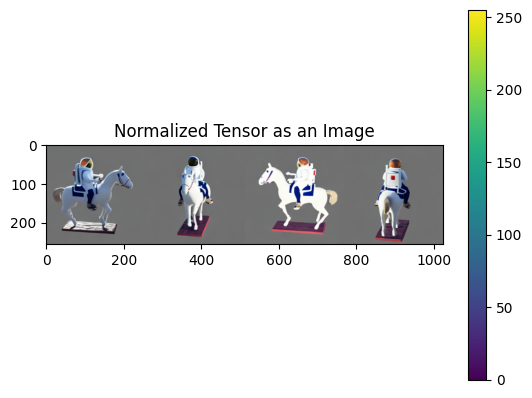

In [9]:
plt.imshow(images[0])
plt.colorbar() # This adds a color bar to the plot, showing the mapping of values to colors
plt.title('Normalized Tensor as an Image')
plt.show()

** Old **

In [3]:
def generate_sample(noise, t, cond):
  with torch.no_grad():
   return model.apply_model(noise, t, cond=cond)

In [5]:
model.eval()
model.cuda()
eps = torch.randn(4,4,32,32, device="cuda") # batch of 4x for 4 views, latent size 32=256/8
cond = {
    "context": model.get_learned_conditioning(["an astronaut riding a horse"]*4).cuda(), # text embeddings
    "camera": get_camera(4).cuda(),
    "num_frames": 4,
}

print(cond["camera"])

# for i in range(999):
#   t = torch.tensor([999-i]*4, dtype=torch.long, device="cuda") # same timestep for 4 views
#   print(i)
#   eps = generate_sample(eps, t, cond)

In [12]:
print(eps.shape)
print(eps[0,0])

torch.Size([4, 4, 32, 32])
tensor([[-2.8179e-01, -1.1754e-02,  3.1732e-01,  ...,  1.0585e-02,
         -1.1158e-01,  5.9369e-02],
        [ 2.1617e-01, -9.9394e-02,  5.8963e-02,  ...,  1.6961e-01,
          8.7498e-04,  7.9160e-02],
        [ 2.1318e-01,  2.1569e-01, -5.5724e-01,  ...,  5.0389e-01,
         -6.0349e-02,  1.1243e-01],
        ...,
        [ 5.4231e-02, -3.3778e-01, -1.0393e-01,  ...,  1.0524e-01,
         -1.8855e-01,  5.2397e-02],
        [ 3.1680e-01, -1.3713e-01, -2.2507e-01,  ...,  7.1323e-01,
         -2.0804e+00, -1.4328e-01],
        [-3.5898e-01,  4.5031e-01,  3.4966e-01,  ...,  8.3054e-01,
         -4.0353e-01,  1.5557e-01]], device='cuda:0')


torch.Size([4, 32, 32])


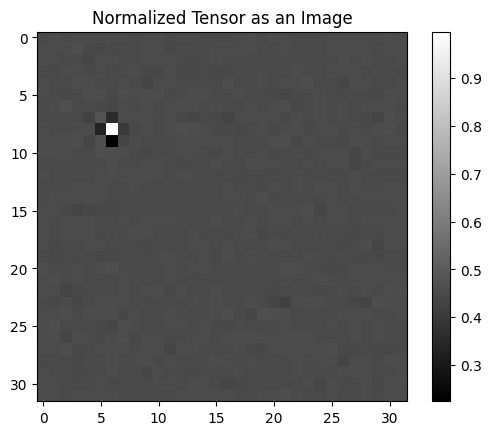

In [15]:
tensor_data = eps[1]
# Normalize the tensor data between 0 and 1 for better visualization
min_v = torch.min(eps)
max_v = torch.max(eps)
normalized_tensor = (tensor_data - min_v) / (max_v - min_v)
input = normalized_tensor.cpu()
print(input.shape)
# Plot the normalized tensor as an image
plt.imshow(input[3], cmap='gray')
plt.colorbar() # This adds a color bar to the plot, showing the mapping of values to colors
plt.title('Normalized Tensor as an Image')
plt.show()